# 1. Import Libraries

In [1]:
import os

# Download the latest version
os.system("pip install -r requirements.txt")
os.system("python -m pip install --upgrade certifi")

0

# 2. Download Dataset

In [2]:
import kagglehub
import shutil

# Process dataset and train model
dataset_path = kagglehub.dataset_download("niharika41298/yoga-poses-dataset")
shutil.move(dataset_path, "./Dataset")

E:\Projects\DeepLearnin-YogaPose\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 288M/288M [00:24<00:00, 12.3MB/s] 

Extracting files...


'./Dataset\\1'

# 3. Process Dataset

Processing warrior2: 100%|██████████| 252/252 [00:29<00:00,  8.46it/s]


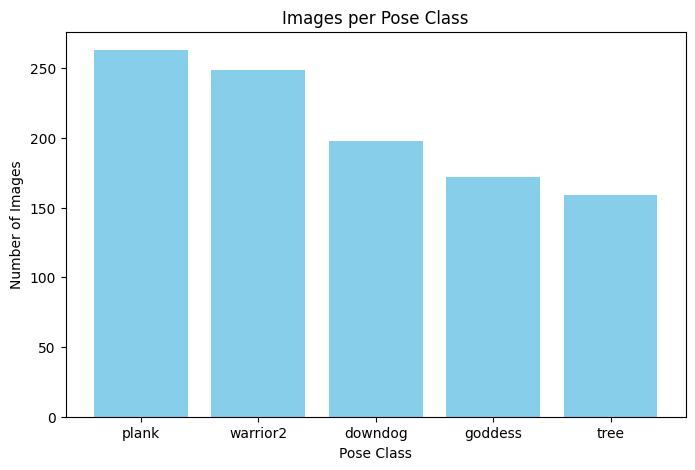

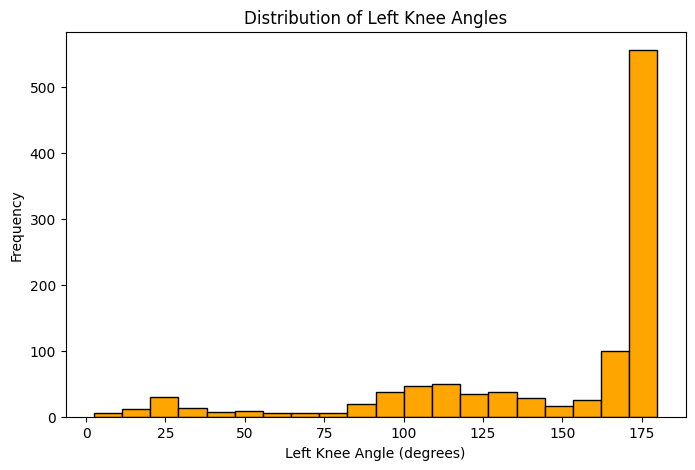

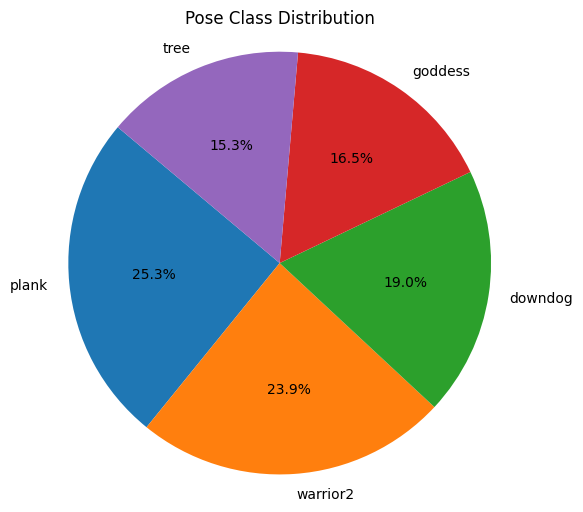

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import mediapipe as mp
import matplotlib.pyplot as plt

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)


def calculate_angle(a, b, c):
    """Calculate the angle between three points"""
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    return np.degrees(np.arccos(np.clip(cosine_angle, -1, 1)))


def extract_features(image_path):
    """Extract both image and biomechanical features from a single image"""
    img = cv2.imread(image_path)
    if img is None:
        return None

    # Process image with MediaPipe
    results = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    if not results.pose_landmarks:
        return None

    # Get landmarks
    landmarks = results.pose_landmarks.landmark

    # Calculate key angles
    points = {
        'left_shoulder': [landmarks[11].x, landmarks[11].y],
        'right_shoulder': [landmarks[12].x, landmarks[12].y],
        'left_elbow': [landmarks[13].x, landmarks[13].y],
        'right_elbow': [landmarks[14].x, landmarks[14].y],
        'left_wrist': [landmarks[15].x, landmarks[15].y],
        'right_wrist': [landmarks[16].x, landmarks[16].y],
        'left_hip': [landmarks[23].x, landmarks[23].y],
        'right_hip': [landmarks[24].x, landmarks[24].y],
        'left_knee': [landmarks[25].x, landmarks[25].y],
        'right_knee': [landmarks[26].x, landmarks[26].y],
        'left_ankle': [landmarks[27].x, landmarks[27].y],
        'right_ankle': [landmarks[28].x, landmarks[28].y]
    }

    angles = {
        'left_elbow': calculate_angle(points['left_shoulder'], points['left_elbow'], points['left_wrist']),
        'right_elbow': calculate_angle(points['right_shoulder'], points['right_elbow'], points['right_wrist']),
        'left_shoulder': calculate_angle(points['left_elbow'], points['left_shoulder'], points['left_hip']),
        'right_shoulder': calculate_angle(points['right_elbow'], points['right_shoulder'], points['right_hip']),
        'left_hip': calculate_angle(points['left_shoulder'], points['left_hip'], points['left_knee']),
        'right_hip': calculate_angle(points['right_shoulder'], points['right_hip'], points['right_knee']),
        'left_knee': calculate_angle(points['left_hip'], points['left_knee'], points['left_ankle']),
        'right_knee': calculate_angle(points['right_hip'], points['right_knee'], points['right_ankle']),
        'spine': calculate_angle(points['left_shoulder'], points['left_hip'], points['left_ankle'])
    }

    # Prepare image for CNN
    img_resized = cv2.resize(img, (224, 224))
    img_normalized = img_resized / 255.0

    return {
        'image': img_normalized,
        'angles': list(angles.values()),
        'landmarks': points
    }


def process_dataset(dataset_path):
    """Process the entire dataset and save features"""
    data = []
    pose_classes = [d for d in os.listdir(dataset_path)
                    if os.path.isdir(os.path.join(dataset_path, d))]

    for pose_class in pose_classes:
        class_dir = os.path.join(dataset_path, pose_class)
        image_files = [f for f in os.listdir(class_dir)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for img_file in tqdm(image_files, desc=f"Processing {pose_class}"):
            img_path = os.path.join(class_dir, img_file)
            features = extract_features(img_path)

            if features is not None:
                features['class'] = pose_class
                data.append(features)

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Bar Chart: Number of Images per Pose Class
    class_counts = df['class'].value_counts()
    plt.figure(figsize=(8, 5))
    plt.bar(class_counts.index, class_counts.values, color='skyblue')
    plt.xlabel('Pose Class')
    plt.ylabel('Number of Images')
    plt.title('Images per Pose Class')
    plt.show()

    # Histogram: Distribution of a Specific Angle (e.g., left_knee)
    left_knee_angles = [angles[6] for angles in df['angles']]
    plt.figure(figsize=(8, 5))
    plt.hist(left_knee_angles, bins=20, color='orange', edgecolor='black')
    plt.xlabel('Left Knee Angle (degrees)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Left Knee Angles')
    plt.show()

    # Pie Chart: Proportion of Each Pose Class
    plt.figure(figsize=(6, 6))
    plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Pose Class Distribution')
    plt.axis('equal')
    plt.show()

    # Save processed data
    df.to_pickle("./Model/yoga_dataset_processed.pkl")

    # Calculate pose standards
    pose_standards = df.groupby('class')['angles'].apply(
        lambda x: {
            'median': np.median(np.vstack(x), axis=0),
            'std': np.std(np.vstack(x), axis=0)
        }
    ).to_dict()

    with open('./Model/pose_standards.pkl', 'wb') as f:
        pickle.dump(pose_standards, f)

    return df, pose_standards


if __name__ == "__main__":
    dataset_path = "Dataset/1/DATASET/TRAIN"
    df, standards = process_dataset(dataset_path)

# 4. Modeling
## Create a Hybrid Model

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.2366 - loss: 43.0669

26/26 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.2375 - loss: 42.7021 - val_accuracy: 0.4593 - val_loss: 6.4513 - learning_rate: 0.0010
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.4171 - loss: 11.1872

26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 881ms/step - accuracy: 0.4182 - loss: 11.0471 - val_accuracy: 0.7368 - val_loss: 1.2967 - learning_rate: 0.0010
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.5657 - loss: 1.6975

26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 853ms/step - accuracy: 0.5657 - loss: 1.6938 - val_accuracy: 0.6172 - val_loss: 1.0628 - learning_rate: 0.0010
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.5810 - loss: 1.1470

26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 790ms/step - accuracy: 0.5803 - loss: 1.1471 - val_accuracy: 0.6651 - val_loss: 0.9757 - learning_rate: 0.0010
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.5769 - loss: 1.1311

26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 824ms/step - accuracy: 0.5776 - loss: 1.1295 - val_accuracy: 0.6890 - val_loss: 0.9594 - learning_rate: 0.0010
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 796ms/step - accuracy: 0.6322 - loss: 0.9878 - val_accuracy: 0.6986 - val_loss: 0.9659 - learning_rate: 0.0010
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.6110 - loss: 1.0638

26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 798ms/step - accuracy: 0.6112 - loss: 1.0630 - val_accuracy: 0.7321 - val_loss: 0.9145 - learning_rate: 0.0010
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.6473 - loss: 0.9244

26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 803ms/step - accuracy: 0.6469 - loss: 0.9252 - val_accuracy: 0.6938 - val_loss: 0.9129 - learning_rate: 0.0010
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.6536 - loss: 0.8771

26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 780ms/step - accuracy: 0.6537 - loss: 0.8788 - val_accuracy: 0.7129 - val_loss: 0.8826 - learning_rate: 0.0010
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 775ms/step - accuracy: 0.6360 - loss: 0.9243 - val_accuracy: 0.7129 - val_loss: 0.8855 - learning_rate: 0.0010


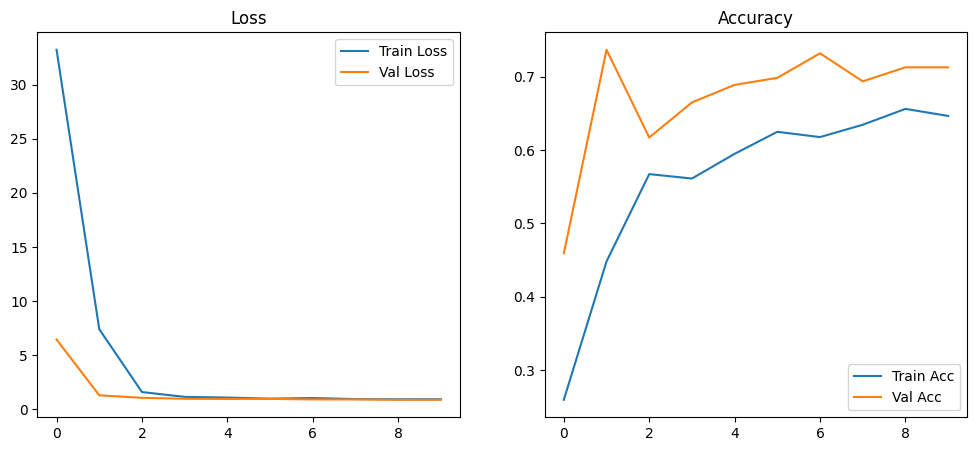

Final Validation Accuracy: 71.29%
Final Validation Loss: 88.26%


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt


def create_hybrid_model(num_classes=5):
    """Create a model that combines CNN and biomechanical features"""
    # Image branch (CNN)
    image_input = layers.Input(shape=(224, 224, 3), name='image_input')

    x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Angle branch
    angle_input = layers.Input(shape=(9,), name='angle_input')
    a = layers.Dense(32, activation='relu')(angle_input)

    # Combined features
    combined = layers.concatenate([x, a])

    # Classifier
    z = layers.Dense(128, activation='relu')(combined)
    z = layers.Dropout(0.5)(z)
    output = layers.Dense(num_classes, activation='softmax')(z)

    return models.Model(inputs=[image_input, angle_input], outputs=output)


def prepare_data(df):
    """Prepare data for training"""
    # Convert images to array
    X_images = np.array([x for x in df['image']])

    # Convert angles to array
    X_angles = np.array([x for x in df['angles']])

    # Convert labels to one-hot
    class_to_idx = {cls: i for i, cls in enumerate(df['class'].unique())}
    y = tf.keras.utils.to_categorical(df['class'].map(class_to_idx))

    return X_images, X_angles, y, class_to_idx


def train_model():
    # Load processed data
    df = pd.read_pickle('Model/yoga_dataset_processed.pkl')

    # Prepare data
    X_img, X_ang, y, class_to_idx = prepare_data(df)

    # Split data - USE THE SAME VARIABLE NAMES RETURNED FROM prepare_data()
    (X_img_train, X_img_val,
     X_ang_train, X_ang_val,
     y_train, y_val) = train_test_split(X_img, X_ang, y, test_size=0.2)

    # Create model
    model = create_hybrid_model(num_classes=len(class_to_idx))

    # Compile
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks
    training_callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint('best_model.h5', save_best_only=True),
        ReduceLROnPlateau(factor=0.1, patience=3)
    ]

    # Train
    history = model.fit(
        x={'image_input': X_img_train, 'angle_input': X_ang_train},
        y=y_train,
        validation_data=({'image_input': X_img_val, 'angle_input': X_ang_val}, y_val),
        epochs=10,
        batch_size=32,
        callbacks=training_callbacks
    )

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

    # Save class mapping
    idx_to_class = {v: k for k, v in class_to_idx.items()}  # Reverse mapping
    with open('Model/class_mapping.pkl', 'wb') as f:
        pickle.dump(idx_to_class, f)  # New: {0:'downdog', 1:'warrior'}

    val_loss, val_acc = model.evaluate(
        {'image_input': X_img_val, 'angle_input': X_ang_val},
        y_val,
        verbose=0
    )
    print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")
    print(f"Final Validation Loss: {val_loss * 100:.2f}%")

    return model, history


if __name__ == "__main__":
    model, history = train_model()

## Trying pre-trained model 1 (MobileNetV2)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.3047 - loss: 10.8484

26/26 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3095 - loss: 10.6863 - val_accuracy: 0.7703 - val_loss: 0.6941 - learning_rate: 0.0010
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.6699 - loss: 1.2613

26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6708 - loss: 1.2570 - val_accuracy: 0.9043 - val_loss: 0.3866 - learning_rate: 0.0010
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.7574 - loss: 0.8142

26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7577 - loss: 0.8125 - val_accuracy: 0.9091 - val_loss: 0.3079 - learning_rate: 0.0010
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.8334 - loss: 0.5394

26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8336 - loss: 0.5388 - val_accuracy: 0.9043 - val_loss: 0.2892 - learning_rate: 0.0010
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.8481 - loss: 0.4689

26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8485 - loss: 0.4685 - val_accuracy: 0.9330 - val_loss: 0.2510 - learning_rate: 0.0010
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.8664 - loss: 0.4587

26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 960ms/step - accuracy: 0.8664 - loss: 0.4586 - val_accuracy: 0.9282 - val_loss: 0.2483 - learning_rate: 0.0010
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.8552 - loss: 0.4501

26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 962ms/step - accuracy: 0.8555 - loss: 0.4494 - val_accuracy: 0.9378 - val_loss: 0.1893 - learning_rate: 0.0010
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.8771 - loss: 0.3815

26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 961ms/step - accuracy: 0.8774 - loss: 0.3798 - val_accuracy: 0.9569 - val_loss: 0.1654 - learning_rate: 0.0010
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 941ms/step - accuracy: 0.8965 - loss: 0.3508 - val_accuracy: 0.9474 - val_loss: 0.1660 - learning_rate: 0.0010
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 942ms/step - accuracy: 0.9213 - loss: 0.2811 - val_accuracy: 0.9474 - val_loss: 0.1670 - learning_rate: 0.0010


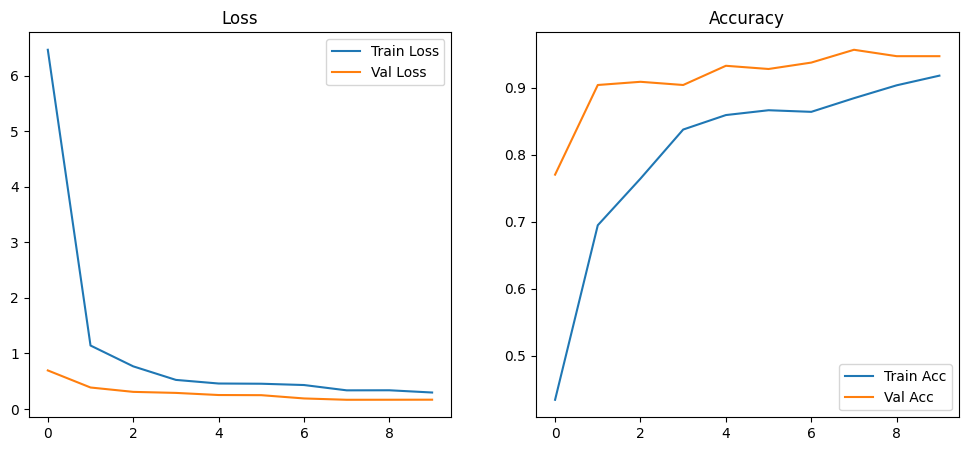

Final Validation Accuracy: 95.69%
Final Validation Loss: 16.54%


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
def create_mobilenet_model(num_classes=5):
    """Create a model using MobileNetV2 as the base"""
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze the base model

    image_input = layers.Input(shape=(224, 224, 3), name='image_input')
    x = base_model(image_input)
    x = layers.GlobalAveragePooling2D()(x)

    angle_input = layers.Input(shape=(9,), name='angle_input')
    a = layers.Dense(32, activation='relu')(angle_input)

    combined = layers.concatenate([x, a])
    z = layers.Dense(128, activation='relu')(combined)
    z = layers.Dropout(0.5)(z)
    output = layers.Dense(num_classes, activation='softmax')(z)

    return models.Model(inputs=[image_input, angle_input], outputs=output)

def train_mobilenet_model():
    # Load processed data
    df = pd.read_pickle('Model/yoga_dataset_processed.pkl')

    # Prepare data
    X_img, X_ang, y, class_to_idx = prepare_data(df)

    # Split data
    (X_img_train, X_img_val,
     X_ang_train, X_ang_val,
     y_train, y_val) = train_test_split(X_img, X_ang, y, test_size=0.2)

    # Create model
    model = create_mobilenet_model(num_classes=len(class_to_idx))

    # Compile
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks
    training_callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint('Model/mobilenet_best_model.h5', save_best_only=True),
        ReduceLROnPlateau(factor=0.1, patience=3)
    ]

    # Train
    history = model.fit(
        x={'image_input': X_img_train, 'angle_input': X_ang_train},
        y=y_train,
        validation_data=({'image_input': X_img_val, 'angle_input': X_ang_val}, y_val),
        epochs=10,
        batch_size=32,
        callbacks=training_callbacks
    )

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

    # Save class mapping
    idx_to_class = {v: k for k, v in class_to_idx.items()}  # Reverse mapping
    with open('Model/class_mapping.pkl', 'wb') as f:
        pickle.dump(idx_to_class, f)  # New: {0:'downdog', 1:'warrior'}

    val_loss, val_acc = model.evaluate(
        {'image_input': X_img_val, 'angle_input': X_ang_val},
        y_val,
        verbose=0
    )
    print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")
    print(f"Final Validation Loss: {val_loss * 100:.2f}%")
    return model, history

if __name__ == "__main__":
    model, history = train_mobilenet_model()
    # Save the model
    model.save('Model/mobilenet_best_model.h5')

## Trying pre-trained model 2 (ResNet50)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3038 - loss: 12.1246

26/26 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.3063 - loss: 11.9505 - val_accuracy: 0.7129 - val_loss: 0.8693 - learning_rate: 0.0010
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5758 - loss: 1.5221

26/26 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.5764 - loss: 1.5109 - val_accuracy: 0.7751 - val_loss: 0.6446 - learning_rate: 0.0010
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6465 - loss: 0.9591

26/26 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.6472 - loss: 0.9565 - val_accuracy: 0.8469 - val_loss: 0.4999 - learning_rate: 0.0010
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7072 - loss: 0.8545

26/26 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.7069 - loss: 0.8535 - val_accuracy: 0.8804 - val_loss: 0.4882 - learning_rate: 0.0010
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7336 - loss: 0.7582

26/26 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.7332 - loss: 0.7588 - val_accuracy: 0.8612 - val_loss: 0.4586 - learning_rate: 0.0010
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7466 - loss: 0.7716

26/26 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.7471 - loss: 0.7691 - val_accuracy: 0.8708 - val_loss: 0.4218 - learning_rate: 0.0010
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7729 - loss: 0.6352

26/26 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.7727 - loss: 0.6359 - val_accuracy: 0.8756 - val_loss: 0.4064 - learning_rate: 0.0010
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7447 - loss: 0.6940

26/26 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.7453 - loss: 0.6928 - val_accuracy: 0.8852 - val_loss: 0.3996 - learning_rate: 0.0010
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7945 - loss: 0.5654

26/26 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.7944 - loss: 0.5666 - val_accuracy: 0.8995 - val_loss: 0.3994 - learning_rate: 0.0010
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7695 - loss: 0.6549

26/26 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.7705 - loss: 0.6529 - val_accuracy: 0.8900 - val_loss: 0.3513 - learning_rate: 0.0010


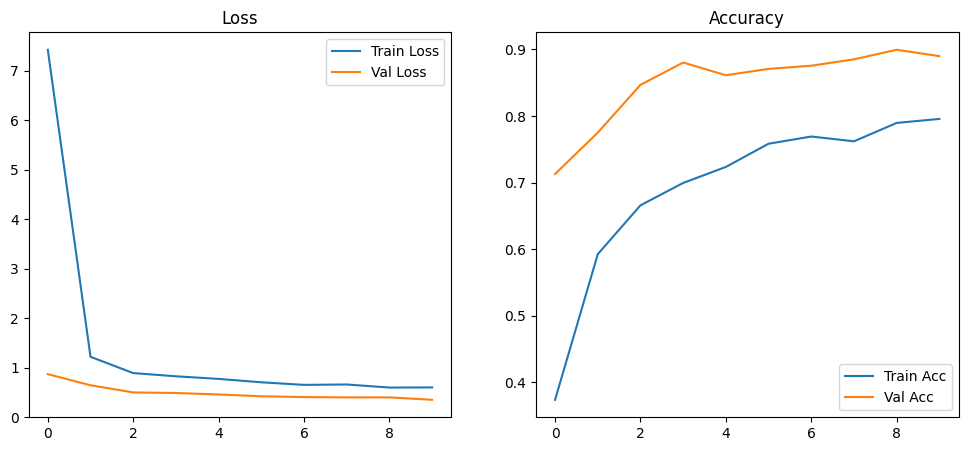

Final Validation Accuracy: 89.00%
Final Validation Loss: 35.13%


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
def create_resnet_model(num_classes=5):
    """Create a model using ResNet50 as the base"""
    base_model = tf.keras.applications.ResNet50(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze the base model

    image_input = layers.Input(shape=(224, 224, 3), name='image_input')
    x = base_model(image_input)
    x = layers.GlobalAveragePooling2D()(x)

    angle_input = layers.Input(shape=(9,), name='angle_input')
    a = layers.Dense(32, activation='relu')(angle_input)

    combined = layers.concatenate([x, a])
    z = layers.Dense(128, activation='relu')(combined)
    z = layers.Dropout(0.5)(z)
    output = layers.Dense(num_classes, activation='softmax')(z)

    return models.Model(inputs=[image_input, angle_input], outputs=output)

def train_resnet_model():
    # Load processed data
    df = pd.read_pickle('Model/yoga_dataset_processed.pkl')

    # Prepare data
    X_img, X_ang, y, class_to_idx = prepare_data(df)

    # Split data
    (X_img_train, X_img_val,
     X_ang_train, X_ang_val,
     y_train, y_val) = train_test_split(X_img, X_ang, y, test_size=0.2)

    # Create model
    model = create_resnet_model(num_classes=len(class_to_idx))

    # Compile
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks
    training_callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint('Model/resnet_best_model.h5', save_best_only=True),
        ReduceLROnPlateau(factor=0.1, patience=3)
    ]

    # Train
    history = model.fit(
        x={'image_input': X_img_train, 'angle_input': X_ang_train},
        y=y_train,
        validation_data=({'image_input': X_img_val, 'angle_input': X_ang_val}, y_val),
        epochs=10,
        batch_size=32,
        callbacks=training_callbacks
    )

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

    # Save class mapping
    idx_to_class = {v: k for k, v in class_to_idx.items()}  # Reverse mapping
    with open('Model/class_mapping.pkl', 'wb') as f:
        pickle.dump(idx_to_class, f)  # New: {0:'downdog', 1:'warrior'}

    val_loss, val_acc = model.evaluate(
        {'image_input': X_img_val, 'angle_input': X_ang_val},
        y_val,
        verbose=0
    )
    print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")
    print(f"Final Validation Loss: {val_loss * 100:.2f}%")
    return model, history

if __name__ == "__main__":
    model, history = train_resnet_model()
    # Save the model
    model.save('Model/resnet_best_model.h5')

# 5. Run Application

In [7]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp
import pickle
import pyttsx3
import time
import threading

# Initialize MediaPipe components
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Configure TensorFlow for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# MediaPipe Pose Configuration
pose = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=1,
    smooth_landmarks=True,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.7
)


# Threaded Voice Engine
class VoiceCoach:
    def __init__(self):
        self.engine = pyttsx3.init()
        self.engine.setProperty('rate', 160)
        self.lock = threading.Lock()

    def speak(self, msg):
        def run():
            with self.lock:
                self.engine.say(msg)
                self.engine.runAndWait()

        threading.Thread(target=run).start()


voice = VoiceCoach()


# Core Functions
def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)

    if angle > 180.0:
        angle = 360 - angle

    return angle


def get_angles(landmarks, frame_shape):
    points = {}
    indices = [11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]  # Shoulders, elbows, wrists, hips, knees, ankles

    for idx in indices:
        landmark = landmarks.landmark[idx]
        points[idx] = [landmark.x * frame_shape[1], landmark.y * frame_shape[0]]

    try:
        angles = np.array([
            calculate_angle(points[11], points[13], points[15]),  # Left elbow
            calculate_angle(points[12], points[14], points[16]),  # Right elbow
            calculate_angle(points[13], points[11], points[23]),  # Left shoulder
            calculate_angle(points[14], points[12], points[24]),  # Right shoulder
            calculate_angle(points[11], points[23], points[25]),  # Left hip
            calculate_angle(points[12], points[24], points[26]),  # Right hip
            calculate_angle(points[23], points[25], points[27]),  # Left knee
            calculate_angle(points[24], points[26], points[28]),  # Right knee
            calculate_angle(points[11], points[23], points[27])  # Spine
        ])
        return points, angles
    except KeyError as e:
        print(f"Missing landmark: {e}")
        return None, None


def predict_pose(model, img_input, angle_input, idx_to_class):
    pred = model.predict({
        'image_input': np.expand_dims(img_input, axis=0),
        'angle_input': np.expand_dims(angle_input, axis=0)
    }, verbose=0)
    return idx_to_class[np.argmax(pred)], np.max(pred)


def get_feedback(pose_name, angles, confidence):
    if angles is None:
        return ["Can't detect all body points"]

    if confidence > 0.95:
        return ["Perfect! Keep going"]

    feedback = []

    if pose_name == "warrior2":
        if angles[6] < 80:
            feedback.append("Bend front knee more")
        elif angles[6] > 100:
            feedback.append("Reduce knee bend")
        if angles[7] < 170: feedback.append("Straighten back leg")

    elif pose_name == "tree":
        if angles[7] < 170: feedback.append("Straighten standing leg")
        if angles[6] > 110: feedback.append("Bring knee inward")

    elif pose_name == "goddess":
        if angles[6] > 120: feedback.append("Sink deeper into squat")
        if angles[8] < 160: feedback.append("Tuck pelvis")

    elif pose_name == "downdog":
        if angles[0] > 170: feedback.append("Microbend elbows")
        if angles[8] < 160: feedback.append("Lift hips higher")

    elif pose_name == "plank":
        if angles[8] < 160: feedback.append("Straighten body line")
        if angles[0] > 170: feedback.append("Soften elbows")

    return feedback[:1] if feedback else ["Adjust your pose"]


# Main Application
def main():
    # Load model
    model = tf.keras.models.load_model('Model/best_model.h5')
    with open('Model/class_mapping.pkl', 'rb') as f:
        idx_to_class = pickle.load(f)

    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

    last_feedback = time.time()
    prev_pose = None

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Process frame
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            points, angles = get_angles(results.pose_landmarks, frame.shape)

            if angles is not None:
                img_input = cv2.resize(rgb, (224, 224)) / 255.0
                pose_name, confidence = predict_pose(model, img_input, angles, idx_to_class)

                # Display angles for debugging
                angle_text = " ".join([f"{a:.1f}°" for a in angles])
                cv2.putText(frame, angle_text, (30, 100),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

                # Give feedback periodically
                if time.time() - last_feedback > 3:
                    feedback = get_feedback(pose_name, angles, confidence)
                    if feedback:
                        voice.speak(feedback[0])
                        cv2.putText(frame, feedback[0], (30, 50),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)
                        last_feedback = time.time()

                # Draw landmarks
                mp_drawing.draw_landmarks(
                    frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2),
                    connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
                )

                # Display pose info
                cv2.putText(frame, f"{pose_name} ({confidence:.2f})", (30, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

        cv2.imshow('Yoga Coach (Q to quit)', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


if __name__ == "__main__":
    main()